In [1]:
import numpy as np
import pandas as pd
import random
import cv2
import os
import math
import copy
import warnings
from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from statistics import stdev

import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [2]:
!pip install imutils
from imutils import paths

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=d01da612056281396543cbfc2792f711a5b897883738ee07ac3c4c4cc2065fec
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


### Todo

create subset of clients

- increase comm rounds 300
- increase hidden units 400
- increase no of layers
- no of clients 20

In [3]:
debug = 0

In [4]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels        
        im_gray = cv2.imread(imgpath , cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten() # cv2.imread(imgpath) 
        # print(image.shape)
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    
    return data, labels

def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)  # <- IID
    
    # sort data for non-iid
#     max_y = np.argmax(label_list, axis=-1)
#     sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
#     data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 


def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(data, 
                                                    label, 
                                                    train_size=0.8,
                                                    test_size=0.2, 
                                                    random_state=42)
    train_dataset = tf.data.Dataset.from_tensor_slices((list(X_data_train), list(y_data_train)))
    test_dataset = tf.data.Dataset.from_tensor_slices((list(X_data_test), list(y_data_test)))
    return (train_dataset.shuffle(len(y_data_train)).batch(bs), test_dataset.batch(bs), y_data_test)


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    
    
    if debug:
        print('global_count', global_count, 'local_count', local_count, 'bs', bs)
    
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean.numpy())
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss



In [5]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model
    
    def build_adv(shape, classes):
        model = Sequential()
        model.add(Input(shape=(shape[0], shape[1], shape[2])))
        #model.add(Lambda(lambda x: expand_dims(x, axis=-1)))
        model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D())
        model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D())
        model.add(Activation("relu"))
        model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D())
        model.add(Activation("relu"))
        model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D())
        model.add(Flatten())
        model.add(Dense(32))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

In [6]:
#declear path to your mnist data folder
img_path = '../input/mnistasjpg/trainingSet/trainingSet' #'../input/cifar10-pngs-in-folders/cifar10/test'  # <-- test dataset #'../input/mnistasjpg/trainingSample/trainingSample' # <-- smaller dataset

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply our function
image_list, label_list = load(image_paths, verbose=10000)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

[INFO] processed 10000/42000
[INFO] processed 20000/42000
[INFO] processed 30000/42000
[INFO] processed 40000/42000


In [7]:
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=42)

### IID

In [8]:
len(X_train), len(X_test), len(y_train), len(y_test)

(37800, 4200, 37800, 4200)

In [9]:
#create clients
clients = create_clients(X_train, y_train, num_clients=100, initial='client')

In [10]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [11]:
lr = 0.01
comms_round = 20 # 300
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

In [12]:
#initialize global model

build_shape = 784 #(28, 28, 3)  # 1024 <- CIFAR-10    # 784 # for MNIST

smlp_global = SimpleMLP()
global_model = smlp_global.build(build_shape, 10) 
global_acc_list = []
global_loss_list = []

### Non-IID

In [66]:
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    # data = list(zip(image_list, label_list))
    # random.shuffle(data)  # <- IID
    
    # sort data for non-iid
    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [67]:
len(X_train), len(X_test), len(y_train), len(y_test)

(37800, 4200, 37800, 4200)

In [68]:
#create clients
clients = create_clients(X_train, y_train, num_clients=100, initial='client')

In [69]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [70]:
lr = 0.01 
local_rounds = 5
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

In [71]:
def freeze_all_except_out(model):
    for layer in global_model.layers[:-2]:
        layer.trainable=False

In [72]:
#initialize global model
def initialize_global_model():
    build_shape = 784 #(32, 32, 3)  # 1024 <- CIFAR-10    # 784 # for MNIST
    smlp_global = SimpleMLP()
    global_model = smlp_global.build(build_shape, 10) 
    global_acc_list = []
    global_loss_list = []

In [73]:
def build_model():
        smlp = SimpleMLP()
        model = smlp.build(build_shape, 10)
        model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        return model

In [74]:
def get_last_dense_layer_weights(model):
    return model.layers[-2].get_weights()

def weight_sigmoid(omega1, omega2, disc, certainty):
    return max(0, omega1/(1 + math.exp(-disc/100)) - omega2)*certainty

def compute_fa_fo_wg(my_detailed_f1, detailed_f1, fi=10, mu=0.9, omega_fa1=0.99, omega_fa2=0.1, omega_fo1=0.5, omega_fo2=0.5):
    disc = [0]*len(my_detailed_f1)
    fa_wg = [0]*len(my_detailed_f1)
    fo_columns = [0]*len(my_detailed_f1)
    
    best = sorted(detailed_f1, reverse=True)[:fi]
    certainty = max(sum(best)/len(best) - stdev(best), 0) if len(best) > 0 else 0
            
    for c in range(len(my_detailed_f1)):
        if detailed_f1[c] > 0 and my_detailed_f1[c] == 0:
            fo_columns[c] == 1
            
        weighed_diff = (detailed_f1[c] - my_detailed_f1[c])*mu
        if detailed_f1[c] > my_detailed_f1[c]:
            disc[c] = weighed_diff**(3 + my_detailed_f1[c])
        else:
            disc[c] = -math.inf #-1*pow(weighed_diff, 4 + int(my_detailed_f1[c]))

        fa_wg[c] = weight_sigmoid(omega_fa1, omega_fa2, disc[c], certainty)  

    fo_wg = weight_sigmoid(omega_fo1, omega_fo2, sum(disc), certainty)
    return fa_wg, fo_wg, fo_columns

def layers_weighted_average(my_layer, layer_list, fa_wg_list, fo_columns_list):
    my_new_layer = copy.deepcopy(my_layer)
    total_weights = [1]*len(my_layer[1])
    for i in range(len(layer_list)):
        for c in range(len(my_layer[1])):
            my_new_layer[1][c] = my_layer[1][c] + layer_list[i][1][c]*fa_wg_list[i][c]
            total_weights[c] += fa_wg_list[i][c]
            
    for c in range(len(my_layer)):
        my_new_layer[1][c] = my_new_layer[1][c]/total_weights[c]
    
    return my_new_layer
        

In [75]:
def calc_F1(test_data_tf,  y_local_test, model, labels = [0,1,2,3,4,5,6,7,8,9], logits = None, fi=10):
    if logits == None:
        logits = model.predict(test_data_tf)

    detailed_f1 = f1_score(tf.argmax(logits, axis=1), tf.argmax(y_local_test, axis=1), average=None, labels=labels, zero_division=1)
    f1 = f1_score(tf.argmax(logits, axis=1), tf.argmax(y_local_test, axis=1), average='macro', labels=labels, zero_division=1)

    return f1, detailed_f1

In [76]:
def weighed_aggretate(weight_list, factors = []):
    if factors == []:
        factors = [1]*len(weight_list)
    
    for i in range(len(weight_list)):
        weight_list[i] = scale_model_weights(weight_list[i], factors[i]/sum(factors))
        
    return sum_scaled_weights(weight_list)

In [77]:
def local_train(client, model, local_rounds = 5, verbose = 0):
    #fit local model with client's data
    train_ds, _, _ = clients_batched[client]
    model.fit(train_ds, epochs=local_rounds, verbose=verbose)
    return model

In [78]:
def has_foreign_classes(my_f1, other_f1):
    for i in range(len(my_f1)):
        if my_f1[i] == 0 and other_f1[i] > 0:
            return True
    return False

In [79]:
def local_rank(model, local_layer_list,test_data_tf, y_local_test, my_f1, my_detailed_f1, count = 5, min_f1 = .3, exclude_foreign_classes = False):
    f1_list = []
    f1_detailed_list = []
    layer_list = []
    for layer in local_layer_list:
        model = reconstruct_model(model.get_weights(), layer)
        f1, detailed_f1 = calc_F1(test_data_tf, y_local_test, model)

        if exclude_foreign_classes and has_foreign_classes(my_detailed_f1, detailed_f1):
            continue
        if f1 < min_f1:
            continue
            
        f1_list.append(f1)
        f1_detailed_list.append(detailed_f1)
        layer_list.append(layer)
    
    indexes = sorted(range(len(f1_list)), key=lambda i: f1_list[i])[-count:]
    return [f1_list[x] for x in indexes], [f1_detailed_list[x] for x in indexes], [layer_list[x] for x in indexes]

In [80]:
def reconstruct_model(base_model_weights, last_dense_layer):
    model = build_model()
    model.set_weights(base_model_weights)
    model.layers[-2].set_weights(last_dense_layer)
    return model

In [81]:
def local_aggregate(i, global_model_weights, local_layer_list, new_local_layer_list, clients_batched, client_names, train_before_aggregation = False, train_after_aggregation = True):
    my_dense_layer = local_layer_list[i]
    _, test_data_tf,  y_local_test = clients_batched[client_names[i]]
    my_model = reconstruct_model(global_model_weights, my_dense_layer)
    
    if train_before_aggregation:
        my_model = local_train(client_names[i], my_model)
        
    my_f1, my_detailed_f1 = calc_F1(test_data_tf, y_local_test, my_model)
    top_f1_values, top_ranked_weights, layer_list = local_rank(my_model, local_layer_list, test_data_tf, y_local_test, my_f1, my_detailed_f1) 
    top_f1_values.append(my_f1)
    top_ranked_weights.append(my_dense_layer)
    if len(top_ranked_weights) > 1:
        my_weights = weighed_aggretate(top_ranked_weights, top_f1_values)

    if train_after_aggregation:
        my_model = local_train(client_names[i], my_model)
        
    new_local_layer_list[i] = get_last_dense_layer_weights(my_model)

In [113]:
comms_round = 30
local_comm_rounds = 5
LOCAL_AGGREGATE = False

In [ ]:
initialize_global_model()
prev_local_layer_list = []
#randomize client data - using keys
all_client_names = list(clients_batched.keys())
           
client_names = random.sample(all_client_names, k=10)
random.shuffle(client_names)

client0 = client_names[0]
global_model = local_train(client0, global_model, 50)
freeze_all_except_out(global_model)
    

#commence global training loop
for comm_round in range(comms_round):

    #initial list to collect local model weights after scalling
    local_layer_list = list()

    #loop through each client and create new local model
    # and publish to IPFS
    
    for client in client_names:
        local_model = local_train(client, global_model, 10)
        local_layer_list.append(get_last_dense_layer_weights(local_model))

        K.clear_session()


    new_local_layer_list = integrate_classes_all(local_layer_list)
    last_dense_layer = weighed_aggretate(new_local_layer_list)
    
    #update global model 
    global_model = reconstruct_model(global_model.get_weights(), last_dense_layer)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)

comm_round: 0 | global_acc: 83.452% | global_loss: 1.6651793718338013
comm_round: 1 | global_acc: 80.833% | global_loss: 1.6870331764221191
comm_round: 2 | global_acc: 78.905% | global_loss: 1.700716495513916
comm_round: 3 | global_acc: 77.595% | global_loss: 1.7110692262649536
comm_round: 4 | global_acc: 76.429% | global_loss: 1.720021367073059
comm_round: 5 | global_acc: 75.714% | global_loss: 1.7270991802215576
comm_round: 6 | global_acc: 75.071% | global_loss: 1.7331316471099854
comm_round: 7 | global_acc: 74.500% | global_loss: 1.7380084991455078
comm_round: 8 | global_acc: 73.786% | global_loss: 1.7427247762680054
comm_round: 9 | global_acc: 73.238% | global_loss: 1.7468816041946411


In [84]:
local_layer_list = prev_local_layer_list
print([layer[1] for layer in local_layer_list])

[array([-0.00137058, -0.00161013, -0.00094706,  0.0157606 , -0.00239706,
       -0.00153601, -0.0023464 , -0.00217834, -0.0016779 , -0.00169711],
      dtype=float32), array([-0.00171721, -0.00194132, -0.00122578,  0.00558702, -0.00292373,
       -0.00186529, -0.00267201, -0.0029196 ,  0.01174059, -0.00206264],
      dtype=float32), array([-0.00312394, -0.00371929, -0.00304126,  0.00334203, -0.00480541,
        0.00263506,  0.01475392, -0.00461314,  0.00165424, -0.0030822 ],
      dtype=float32), array([-0.00431855, -0.00481561,  0.01816911,  0.00226071, -0.00597243,
        0.0005685 ,  0.00443638, -0.00618939, -0.00013706, -0.00400164],
      dtype=float32), array([-0.00531468, -0.00549416,  0.00648886,  0.00158937, -0.00693997,
        0.02078757,  0.00245676, -0.00742444, -0.00127112, -0.00487818],
      dtype=float32), array([ 0.00937686,  0.0048122 ,  0.00389321,  0.00038882, -0.00860951,
        0.0077091 ,  0.00054363, -0.0088128 , -0.00291903, -0.00638247],
      dtype=float32

In [118]:
def integrate_classes_my_model(my_layer, test_data_tf,  y_local_test):
    my_f1, my_detailed_f1 = calc_F1(test_data_tf, y_local_test, my_model)
    f1_list, detailed_f1_list, layer_list = local_rank(my_model, local_layer_list,test_data_tf, y_local_test, my_f1, my_detailed_f1, 10, 0.0)
    fa_wg_list = []
    fo_wg_list = []
    fo_columns_list = []
    for j in range(len(layer_list)):
        fa, fo, fo_columns = compute_fa_fo_wg(my_detailed_f1, detailed_f1_list[j], fi=9, mu=0.9, omega_fa1=1.0, omega_fa2=0.0001, omega_fo1=0.99, omega_fo2=0.0001)
        fa_wg_list.append(fa)
        fo_wg_list.append(fo)
        fo_columns_list.append(fo_columns)
    my_new_layer = layers_weighted_average(my_layer, layer_list, fa_wg_list, fo_columns_list)
#     print('==========================================')
#     if sum(my_new_layer[1]) != sum(my_layer[1]):
#         print('new layer', my_new_layer[1])
#         print('old layer', my_layer[1])
    return my_new_layer

In [119]:
def integrate_classes_all(local_layer_list):
    new_local_layer_list = []
    for i in range(len(local_layer_list)):
        my_layer = local_layer_list[i]
        _, test_data_tf,  y_local_test = clients_batched[client_names[i]]
#         my_model = reconstruct_model(global_model.get_weights(), my_layer)
        my_new_layer = integrate_classes_my_model(my_layer, test_data_tf,  y_local_test)
        new_local_layer_list.append(my_new_layer)
    return new_local_layer_list

In [105]:
new_local_layer_list = integrate_classes_all(global_model, local_layer_list)

In [109]:
last_dense_layer = weighed_aggretate(new_local_layer_list)
print(last_dense_layer[1])

[-0.00023283  0.00039655 -0.00058604 -0.00049434  0.00019256  0.00059329
  0.0013782   0.00039657 -0.00058491 -0.00045311]


Non-IID | total comm rounds 90


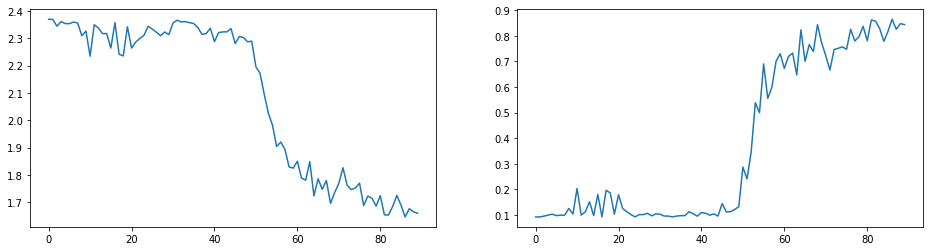

In [115]:
# Non-IID 
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('Non-IID | total comm rounds', len(global_acc_list))           

In [116]:
noniid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
noniid_df.to_csv('CIFAR-10_Non-IID.csv',index=False)